# XAI: Chapter 3 - Improving Explainability

Michael Mayer

# Introduction

> "The best explanation of a simple model is the model itself"

(<a href="#ref-lundberg2017">Lundberg and Lee 2017</a>)

Welcome to the last chapter of the XAI part of the lecture "Responsible Machine Learning with Insurance Applications". It is dedicated to improving the intrinsic explainability of ML models.

Regarding intrinsic explainability, there is the following basic hierarchy:

1. **Linear additive models (like GLMs):** Their model structure is so simple that the effects can be read off directly from the numerical model output.
2. **Additive models (like GAMs):** It is still possible to give a complete description of the effects, but they must be visualized for interpretation. 
3. **Black box models (like boosted trees or neural nets):** These models contain many complex interactions, so that the effects can only be described approximately. Without interaction effects, such models would be additive and as transparent as a GAM.

The boundaries are blurred: GLMs can also include nonlinear effects and interaction terms. If one adds many interaction terms to a GLM or a GAM, it becomes almost as complex as a neural network. On the other hand, the complexity of boosted trees models and neural networks can be reduced by enforcing additivity for all or some features.

In the next two sections, we will learn how to create such additive and partly additive boosted trees and neural nets. By *partly additive*, we mean models that are additive in some features but have interactions between other variables. It is just another term for "additive with (possibly complex) interactions". Examples of such partly additive models in actuarial science are as follows:

- Keep the "time" effect additive while letting the other covariates interact freely. In this way, the ML model can be manually calibrated to obtain unbiased predictions out-of-time.
- Use an additive gender effect while allowing other features to interact. This allows to retrospectively remove a potentially discriminatory gender effect from the ML model. (Why not simply dropping gender from the model?)
- The location can be represented by a complex interaction effect between latitude and longitude, leaving all other features additive for interpretability.
- Same as the last example, but representing location by a large set of (often highly-correlated) features like "distance to next bus stop" or "distance to next restaurant", see Mayer et
al. (<a href="#ref-mayer2022">2022</a>) for two case studies with real-estate data. (How can such models be used for supervised dimension reduction?)
- In a car insurance pricing model, one could use additive features for the driver's  attributes, while allowing the vehicle characteristics (engine size, power, speed, ...) to interact freely.

Furthermore, we will see how monotonic constraints can additionally improve intrinsic interpretability of boosted trees.

**Remarks:**

- Single decision trees do not fit into above hierarchy. They are neither linear nor additive, but still intrinsically interpretable.
- For models with link functions, additivity is meant at the link scale, since the back-transformation to the response scale introduces interaction effects. In most cases, we interpret such a model on the link scale.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import tensorflow as tf
from joblib import load
from keras import layers
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_poisson_deviance
from sklearn.model_selection import ParameterSampler  # , ParameterGrid
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from tensorflow import keras
from tqdm import tqdm
from utils import ColumnSplitter, KerasRegressor, LogRegressor  # utils.py

main = Path("french_motor")

train, test, X_train, X_test, y_train, y_test, w_train, w_test, xvars, prep_lgb = load(
    main / "data.joblib"
)

model_glm, model_gam, model_lgb = models = load(main / "models.joblib")
names = ["GLM", "GAM", "LGB"]

# Needed for clean relative deviance reduction
ref_model = DummyRegressor().fit(X_train, y=y_train, sample_weight=w_train)

c:\Users\mayer\responsible_ml_lecture\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Helper function
def summary_model(
    model,
    ref_model,
    v=["DrivAge", "logDensity", "VehAge", "VehGas"],  # noqa: B006
    shap_dependence=False,
):
    """Calculates performance, and plots c-ICE plots of *numeric* features and SHAP.

    Note that this function is not written in a neat way. We would need to pass
    X_train, X_test, y_test, w_test.

    We set the parameter of PartialDependenceDisplay() so that the evaluation points
    might actually agree with the SHAP dependence plots.
    """

    M = 1000
    X_display = X_train.sample(M, random_state=93)

    # Reference model could be passed as argument
    deviance_0 = mean_poisson_deviance(
        y_test, ref_model.predict(X_test), sample_weight=w_test
    )
    deviance = mean_poisson_deviance(
        y_test, model.predict(X_test), sample_weight=w_test
    )
    deviance_improvement = (deviance_0 - deviance) / deviance_0

    fig, ax = plt.subplots(1, len(v), figsize=(3 * len(v), 3))
    PartialDependenceDisplay.from_estimator(
        LogRegressor(model),
        X=X_display,
        features=v,
        kind="individual",
        centered=True,
        percentiles=(0, 1),
        grid_resolution=M,
        ax=ax,
    )
    fig.suptitle(f"Deviance reduction: {deviance_improvement:.2%}")
    fig.tight_layout()

    if shap_dependence:
        # Model needs to be a pipeline with preprocessing step
        X_explain = model[0].transform(X_display)
        explainer = shap.Explainer(model[-1])
        shap_val = explainer(X_explain)
        shap_val.display_data = X_display[X_explain.columns]  # For dependence plots
        shap.plots.scatter(shap_val[:, v], color=shap_val)

# Structuring Boosted Trees

While the prediction function of a single decision tree is simple to interpret, the same is not true for boosted trees models. Its prediction function
$$
  m(\boldsymbol x) = m_1(\boldsymbol x) + \dots + m_K(\boldsymbol x),
$$
equals the sum of $K \ge 1$ decision trees $m_k$, and one has to rely on post-hoc explainability methods from Chapter 2 to approximately understand $m$. Here, we will learn two ways how to simplify the internal structure of a boosted trees model to improve its (intrinsic) interpretability.
The first approach produces additive models. The second approach is more general and can be also used to fit partly additive models.

## Additive boosted trees

A *tree stump* is a decision tree with a single split. Its prediction function has the form $v_1 + (v_2 - v_1)\mathbb I(x^{(j)} \le s)$, where $\mathbb I$ is the indicator function, $s$ the split position of the selected variable $X^{(j)}$, and $v_1, v_2$ are the values of the left and right leaf. A boosted trees model with tree stumps $m_1, \dots, m_K$ as base learners (boosted tree stumps) is thus an additive model
$$
  m(\boldsymbol x) = f_1(x^{(1)}) + \dots + f_p(x^{(p)})
$$
with piecewise constant functions $f_j$, $1 \le j \le p$. The function $f_j$ equals the sum of all $m_k$ that split on $X^{(j)}$. 

A schematic view of such a model for our French MTPL dataset could look as follows:

<img src="../figs/tree_additive.png" width="80%"/>

Scheme 1: Additive boosted trees.

Unlike the classic GAM (<a href="#ref-hastie1986">Hastie and Tibshirani 1986</a>, <a href="#ref-hastie1990">1990</a>; <a href="#ref-wood2017">Wood
2017</a>), the functions $f_j$ are not smooth, which is a disadvantage in some applications. An advantage of using boosted tree stumps to fit GAMs is that modern boosting implementations can handle large datasets consisting of millions of rows and many covariates, where classic approaches would be too slow. 
The resulting model is as easy to interpret as a classic GAM, i.e., each component $f_j$ can be visualized, for instance, by an ICE or PDP plot that provides a complete description of the effect of that feature. 

Remark: The SHAP dependence plot of an additive feature in a boosted trees model is equivalent to the PDP/ICE plot up to a vertical shift (given the same evaulation points). Thus, like the PDP, it can be interpreted Ceteris Paribus (<a href="#ref-mayer2022b">Mayer 2022</a>).

Additive boosted trees models are discussed in the literature, e.g., in Lou, Caruana, and Gehrke (<a href="#ref-lou2012">2012</a>)</span> and <span class="citation">Nori et
al. (<a href="#ref-nori2019">2019</a>).

### Example

First, we fit an additive Poisson boosted trees model with log-link to the French MTPL data. To force LightGBM to use tree stumps as base learners, we can set either `num_leaves = 2` or `max_depth = 1`. The other parameters have been found by random parameter search using (grouped) five-fold cross-validation. How does the model compare with the classic GAM? 

Besides showing relative deviance gains on the test dataset, throughout this section, we will report c-ICE plots of selected variables. For boosted trees models, we will additionally show corresponding SHAP dependence plots.

First, we analyze the classic GAM, then the additive LightGBM model.

In [3]:
# Found by cross-validation (-> french_motor/tune_additive_lgb.ipynb)
# Of key importance: "num_leaves = 2" or "max_depth = 1"
params = {
    "objective": "poisson",
    "learning_rate": 0.5,
    "num_leaves": 2,
    "reg_lambda": 7.5,
    "reg_alpha": 0,
    "colsample_bynode": 1,
    "subsample": 1,
    "min_child_samples": 50,
    "poisson_max_delta_step": 0.7,
    "verbose": -1,
}

model_lgb_add = Pipeline(
    [
        ("preprocessor", prep_lgb),
        ("model", LGBMRegressor(**params, n_estimators=568, random_state=59)),
    ]
)
_ = model_lgb_add.fit(X=X_train, y=y_train, model__sample_weight=w_train)

GAM


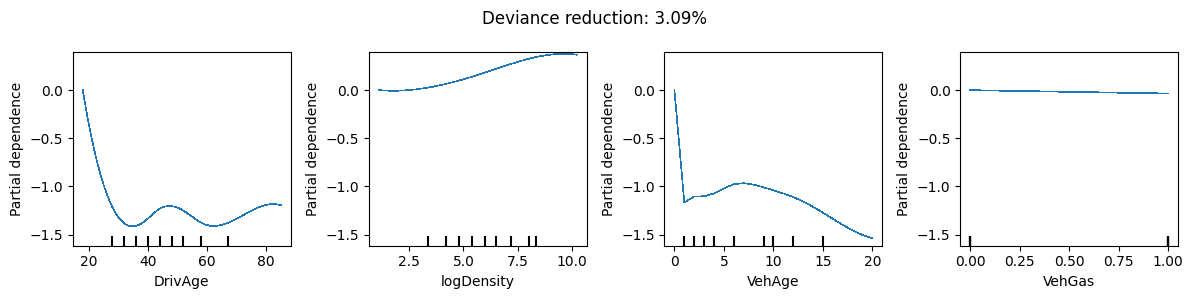

In [4]:
# Inspect traditional GAM and additive boosted trees
print("GAM")
summary_model(model_gam, ref_model=ref_model)

Additive boosted trees


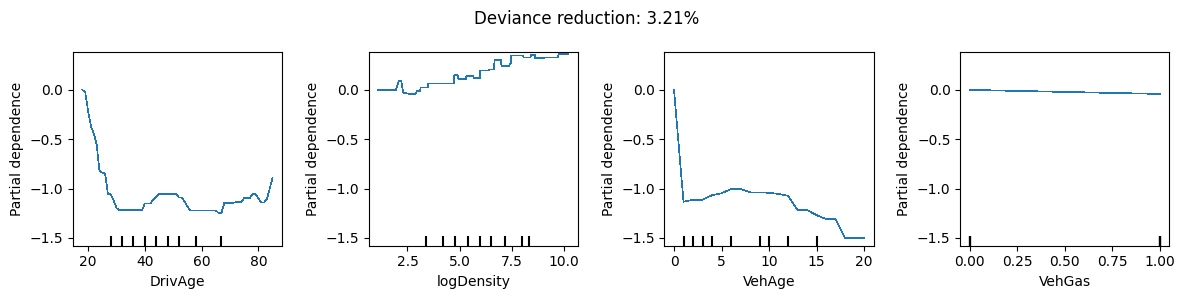

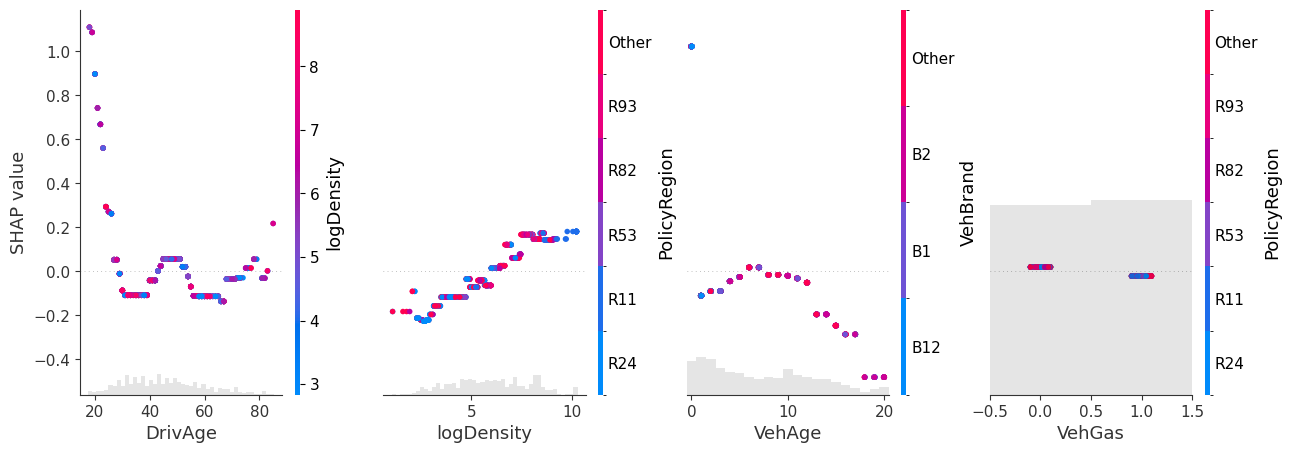

In [5]:
print("Additive boosted trees")
summary_model(model_lgb_add, ref_model=ref_model, shap_dependence=True)

**Comments:**

- c-ICE curves indicate parallel ICE curves, empirically confirming additivity for each covariate and model on the log-scale. 
- The additive LightGBM model performs slightly better than the (classic) GAM model, probably a result of its non-smooth effects.
- Thanks to additivity, the SHAP dependence plots of the LightGBM model indeed provide the same effects as the c-ICE curves.

## Partly additive boosted trees

In many situations, assuming additivity for all features leads to an unrealistically simple model. One way to relax the assumption for boosted trees is to grow trees of depth $\ell > 1$ (not counting the root node). For instance, if $\ell = 2$, the model can learn all pairwise interactions (why?). Similarly, larger tree depths allow higher order interactions to be represented. 

What if we want to model some features additively while using interactions for other features? Such partly additive models can be created by specifying *interaction constraints*
$$
  IC = \{F_1, \dots, F_K\},
$$
where each $F_k \subseteq \mathcal M$ defines a feature subset allowed to interact with each other (<a href="#ref-lee2015">Lee, Lin, and Antonio 2015</a>).

How do interaction constraints work technically? During tree growth, a split considers features only from those $F_k$ that contain all previous split variables of the branch. Consequently, each branch in each tree will only use features from one $F_k \in IC$. This implies the desired structure for the tree and also for a tree ensemble.

Interaction constraints can be used to create partly additive boosted trees models. For instance, to have a model additive in feature $X^{(j)}$, we can set $F_1 = \{X^{(j)}\}$, and make sure that $X^{(j)} \notin F_k, \ k > 1$.

The following scheme shows a partly additive model with interaction constraints
$$
  IC = \{\{\text{DrivAge}\}, \{\text{logDensity}\}, \{\text{PolicyRegion}\}, \{\text{VehAge}, \text{VehBrand}, \text{VehGas}, \text{VehPower}\}\}.
$$
The resulting model will be additive in driver-related features while allowing vehicle features to interact.

<img src="../figs/tree_partly_additive.png" width="80%"/>

Scheme 2a: Partly additive boosted trees.

Remarks: 

- If all elements in $IC$ are disjoint, each tree uses features from only one $F_k$. (The first split variable determines which of the $F_k$.)
- As an alternative to boosted tree stumps, we can specify $IC = \{\{X^{(1)}\}, \dots, \{X^{(p)}\}\}$ to create an additive boosted trees model, see the figure below.

<img src="../figs/tree_additive_ic.png" width="80%"/>

Scheme 2b: Additive boosted trees via interaction constraints.

### Example

Let us now create a model with above structure. We will compare it with the unconstrained LightGBM model.

In [6]:
# Need to work with feature positions *after* preprocessing
xvars_prep = model_lgb[0].get_feature_names_out()
xvars_prep

array(['VehPower', 'VehAge', 'VehGas', 'DrivAge', 'logDensity',
       'VehBrand', 'PolicyRegion'], dtype=object)

In [7]:
# Thus: first three features may interact, other should stay additive on log scale
interaction_constraints = [[0, 1, 2, 5], [3], [4], [6]]

In [8]:
# Found by cross-validation (-> french_motor/tune_partly_additive_lgb.ipynb)
# Of key importance: "interaction_constraints"
params = {
    "objective": "poisson",
    "learning_rate": 0.05,
    "num_leaves": 15,
    "interaction_constraints": interaction_constraints,
    "reg_lambda": 7.5,
    "reg_alpha": 4,
    "colsample_bynode": 1,
    "subsample": 1,
    "min_child_samples": 100,
    "poisson_max_delta_step": 0.1,
    "verbose": -1,
}
nrounds = 358

model_lgb_part_add = Pipeline(
    [
        ("preprocessor", prep_lgb),
        ("model", LGBMRegressor(**params, n_estimators=nrounds, random_state=59)),
    ]
)
_ = model_lgb_part_add.fit(X=X_train, y=y_train, model__sample_weight=w_train)

Unconstrained boosted trees


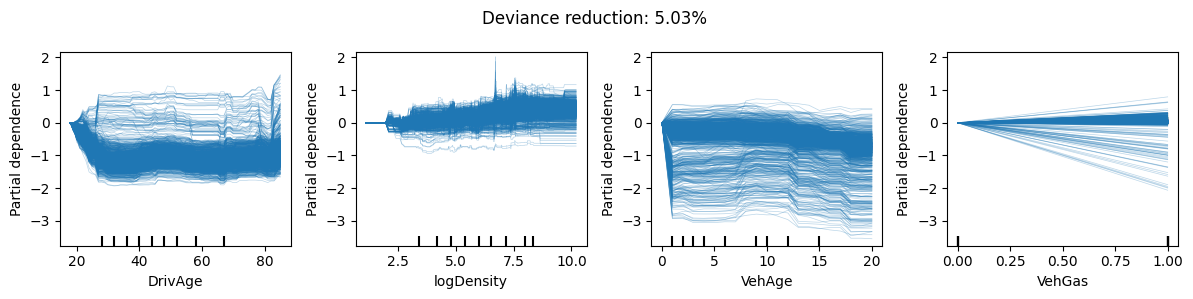

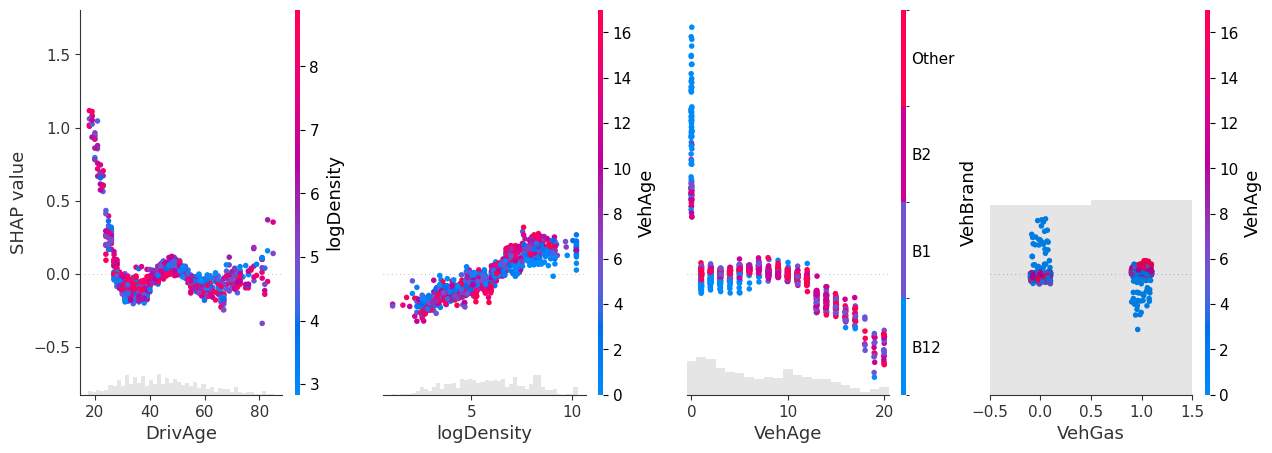

In [9]:
# Inspect unconstrained and constrained LGB models
print("Unconstrained boosted trees")
summary_model(model_lgb, ref_model=ref_model, shap_dependence=True)

Partly additive boosted trees


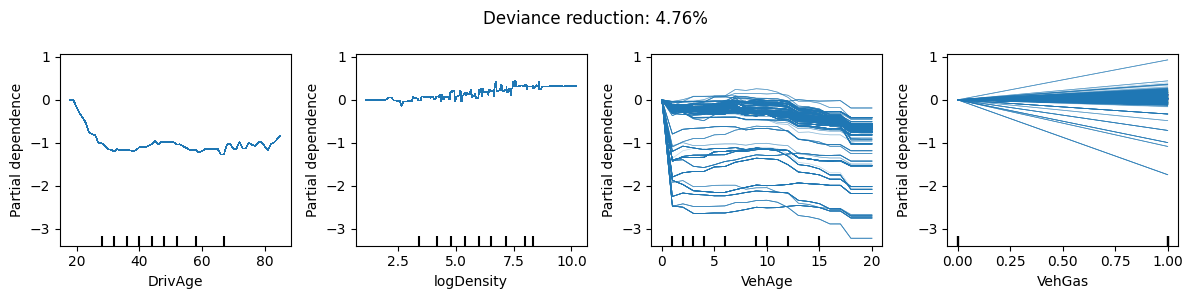

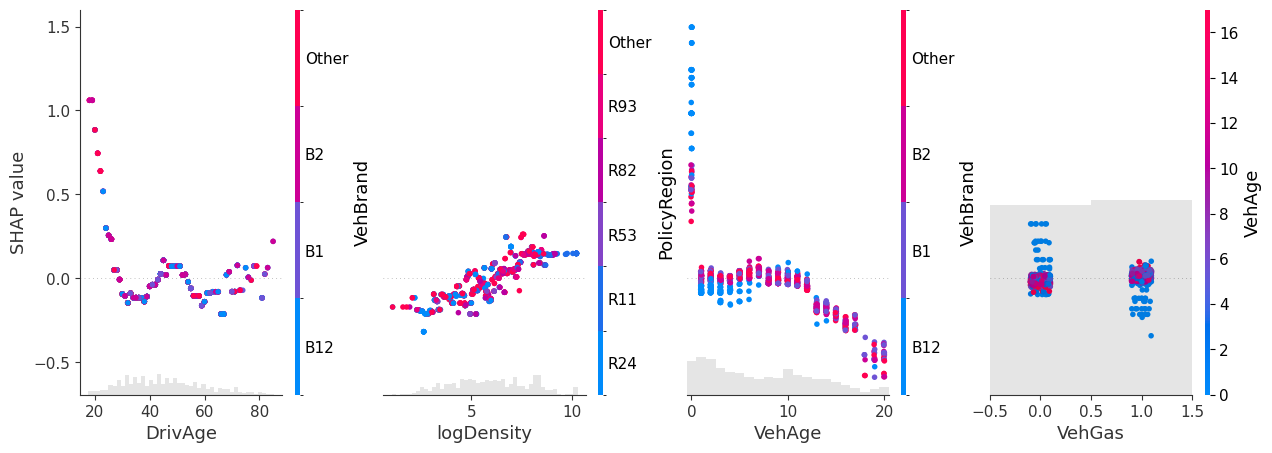

In [10]:
print("Partly additive boosted trees")
summary_model(model_lgb_part_add, ref_model=ref_model, shap_dependence=True)

**Comments:**

- The c-ICE curves of the partly additive model indeed show additive effects for driver-related features and interaction effects for vehicle characteristics. The SHAP analysis confirms this. The original model shows interaction effects for all features.
- The performance of the partly additive model is a bit lower than that of the original, fully flexible LightGBM model.
- The additive effect of "logDensity" is shaky, which is unsatisfactory. It is possible that the model tries to compensate for an omitted interaction. In the next subsection we will use a monotonic constraint to suppress this behavior.

## Monotonic constraints

So far, we have improved the intrinsic interpretability of a black box by removing interactions. For tree-based models, another aspect can be exploited: Monotonicity. 
By monotonicity in a feature, we mean that $m$ is a monotonically increasing or decreasing function in that feature, everything else being fixed.

In practice, the usefulness and trustworthiness of a model can drop dramatically if it fails to satisfy certain monotonic constraints. Here two examples:

- A claims severity model for car collisions is expected to be monotonically increasing in the car value, everything else being fixed.
- A claims frequency model for car collisions is expected to be monotonically decreasing in the deductible, Ceteris Paribus.

How do monotonic constraints work? To enforce monotonicity for the $j$-th feature in a decision tree, the rules are as follows: 

1. A candidate split that violates the condition on its child nodes receives an infinite penalty (or *negative* split gain) and is therefore discarded (Scheme 3a). This enforces monotonicity at this split.
2. To enforce monotonicity also for splits further down the tree, values of child (and grand-child etc.) nodes are capped at the average node values of the constraining split, see Scheme 3b. Capping may introduce a certain amount of bias.

In Scheme 3a, Tree A represents a prediction function (on log claims frequency scale) that is monotonically decreasing in the vehicle age. The split on the lower left of Tree B violates this constraint and is discarded (and replaced by some other split).

<img src="../figs/monotonic.jpg" width="50%"/>

Scheme 3a: Monotonic constraints - basic logic.

Scheme 3b explains how node values of subsequent splits are capped to enforce monotonicity downstream:

<img src="../figs/monotonic_capping.png" width="40%"/>

Scheme 3b: Monotonic constraints - capping explained.

Remarks: 

- Monotonicity also translates to tree ensembles such as boosted trees or random forests.
- Use a monotonic constraint only if it makes sense conditional on all possible combinations of the other features. Take a house price model, for example: At first glance, predictions should increase monotonically with the number of rooms. At second glance, this is not necessarily a good idea, because for a fixed living area, more rooms are not necessarily better.
- A monotonicity constraint helps to reduce wiggliness of an effect.
- Furthermore, it can be combined with interaction constraints.
- There are also implementations of GAMs, GLMs, and neural nets that allow to take monotonicity into account.
- For flexibly modeled effects, violations of desired monotonicity often happens as a consequence of overfitting on outlying feature values, a problem that can already dealt with during feature preprocessing by truncation.

### Example

In our French MTPL example, there is no feature for which we should really impose monotonicity. Nevertheless, to illustrate the effect, we will force a negative effect for "VehAge" and a positive effect for "logDensity" to reduce its wiggliness. Note that "logDensity" is modeled additively, while "VehAge" can freely interact with other vehicle features. For simplicity, we use the same LightGBM parameters as before.

In [11]:
# Build monotonic constraint vector in safe way
monotone_constraints = [(x == "logDensity") - (x == "VehAge") for x in xvars_prep]

In [12]:
params = {
    "objective": "poisson",
    "learning_rate": 0.05,
    "num_leaves": 15,
    "interaction_constraints": interaction_constraints,
    "monotone_constraints": monotone_constraints,
    "reg_lambda": 0,
    "reg_alpha": 4,
    "colsample_bynode": 0.8,
    "subsample": 1,
    "min_child_samples": 100,
    "poisson_max_delta_step": 0.7,
    "verbose": -1,
}
model_lgb_monotone = Pipeline(
    [
        ("preprocessor", prep_lgb),
        ("model", LGBMRegressor(**params, n_estimators=nrounds, random_state=59)),
    ]
)
_ = model_lgb_monotone.fit(X=X_train, y=y_train, model__sample_weight=w_train)

Partly additive boosted trees with monotonic constraints


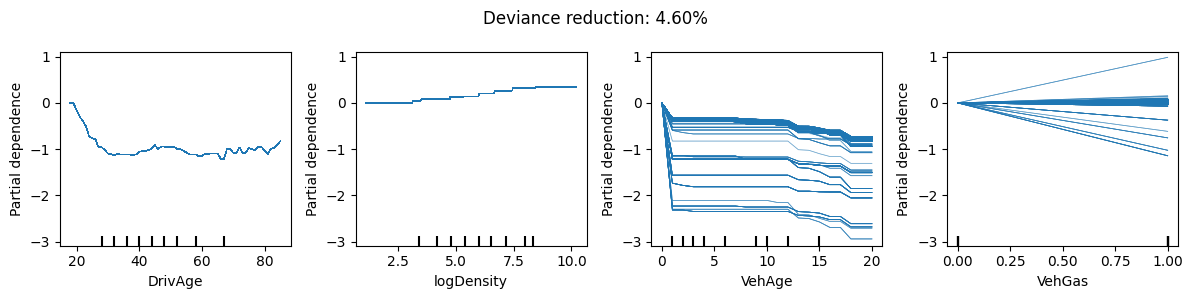

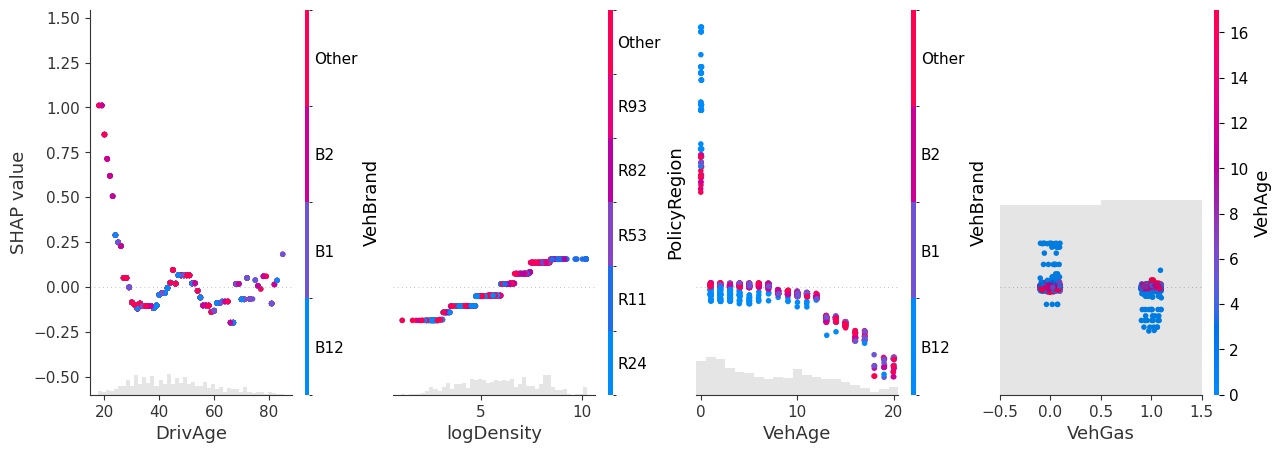

In [13]:
print("Partly additive boosted trees with monotonic constraints")
summary_model(model_lgb_monotone, ref_model=ref_model, shap_dependence=True)

**Comments:**

- Indeed: Ceteris Paribus, the effect of "logDensity" is now monotonically increasing while the effect of "VehAge" decreases for each individual ICE curve. 
- Both effects are less wiggly.
- The model performs not much worse than without monotonicity constraints (and we could re-tune the parameters for an even better result).
- Monotonic constraints combine well with interaction constraints.
- In SHAP dependence plots, monotonicity can only be seen when the feature is modeled additively. Otherwise, the vertical scatter of interaction effects covers it.

# Structuring Neural Nets

In this lecture, we have not yet worked with neural nets. While they are typically not as performant as boosted trees models for tabular data, they are extremely versatile. Here is just a small list of their capabilities: Neural nets can

- mimic models like GLMs or GAMs,
- automatically learn interactions and non-linear effects (like tree-based methods),
- fit data larger than RAM (e.g. images),
- learn "online" (update the model with additional data),
- fit multiple response variables at the same time,
- model input and output of dimension higher than two (images, videos, text, audio),
- model input and output of *different* input dimensions (e.g. text *and* images *and* numbers),
- fit data with sequential structure in both in- and output (e.g., a machine translator),
- fit models with millions of parameters,
- perform non-linear dimension reduction.

We assume that the reader has some background knowledge on neural nets and refer to James et al. (<a href="#ref-james2023">2023</a>)</span> or <span class="citation">Chollet
(<a href="#ref-chollet2017">2017</a>) otherwise. In the examples, we will work with TensorFlow, using the handy Keras front-end. 

Within Keras, we will work with the *functional API*. It allows to represent very general model structures (also called *architectures* in neural network jargon). Actually, any model that can be characterized as a directed acyclic graph (DAG) could be implemented using this interface. Non-trivial examples include additive and partly additive models. 

## A simple neural net

To familiarize ourselves with Keras and get used to neural network terminology, we will first create a very simple neural network - a GLM. It consists of two layers only: The input layer represents the features, and the output layer represents the response variable. The values of the output layer are transformed by the exponential "activation" function, corresponding to the inverse link function of the Poisson GLM. The output layer is *fully connected* or *dense*, which means that the value of its node is a weighted sum of all node values of the previous layer (in this case, of the input layer), see the left hand side of Scheme 4:

<img src="../figs/nn_with_and_without_hidden.jpg" width="80%"/>

Scheme 4: (a) Neural net without hidden layer, (b) with hidden layer.


The weights are the parameters estimated by *gradient descent*. Normally, the gradient descent update steps are computed by backpropagation, which involves applying the chain rule to find the derivatives of the loss function with respect to all parameters. For a simple model like a GLM, this is straightforward. But imagine a deep learning model with 50 hidden layers and a non-linear transformation after each hidden layer! Computing millions or even billions of derivatives (without seeing the data) is one of the greatest achievements of modern deep learning implementations like TensorFlow and PyTorch.

**(Mini-batch) gradient descent with backpropagation works as follows:**

Let $m_\beta$ denote a neural net with parameters $\beta$, and 
$$
  Q(m_\beta, D) = \sum_{(y_i, \boldsymbol x_i) \in D} L(m_\beta(\boldsymbol x_i), y_i)
$$ 
its total loss on a data set $D$ with respect to the loss function $L$.

1. Initialize the parameter vector $\beta$ with random values $\hat \beta$.
2. Forward step: Calculate $Q(m_{\hat\beta}, D_\text{batch})$ on a *batch* $D_\text{batch}$ of observations. This is a small subset of the training data.
3. Backpropagation step: Modify $\hat \beta$ to improve $Q(m_{\hat\beta}, D_\text{batch})$ by gradient descent: Calculate the vector of partial derivatives
$$
  \nabla \hat \beta = \frac{\partial Q(m_\beta, D_\text{batch})}{\partial \beta}\large\mid_{\beta = \hat \beta}
$$
at the current estimates $\hat \beta$. Use it to update
$$
  \hat \beta \leftarrow \hat \beta  - \lambda \nabla \hat \beta,
$$
where $\lambda > 0$ is a sufficiently small learning rate. In neural nets, parameters are organized in multiple layers, which makes it difficult to calculate $\nabla \hat\beta$. This is where backpropagation enters the game: It calculates the partial derivatives layer per layer using the chain rule, starting from the output layer.
4. Repeat Steps 2 and 3 until each observation appeared in a batch. This is called an *epoch*.
5. Repeat Step 4 for multiple epochs until some stopping criterion triggers.

Remarks:

- Step 5 can be specified by an early-stopping *callback*. A callback is an action executed during training. An other callback would be to save the parameters after each epoch.
- To improve convergence, input variables should be on a comparable scale. We will standardize them accordingly by subtracting their (training) mean and then dividing by the (training) standard deviation. Alternatively, we could scale the values of each feature so that they range from $0$ to $1$ (min-max scaling) or from $-1$ to $1$.

### Example: a GLM neural net

Let us now fit a claims frequency GLM with Keras/TensorFlow, i.e., the model in Scheme 4 (a). For simplicity, we encode all factor variables as integers, even if this is not always intelligent (see later examples how to create better models). We use a learning rate of 0.02. This means that each parameter update takes 0.02 steps towards the negative gradient.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8 (32.00 B)

 Trainable params: 8 (32.00 B)

 Non-trainable params: 0 (0.00 B)

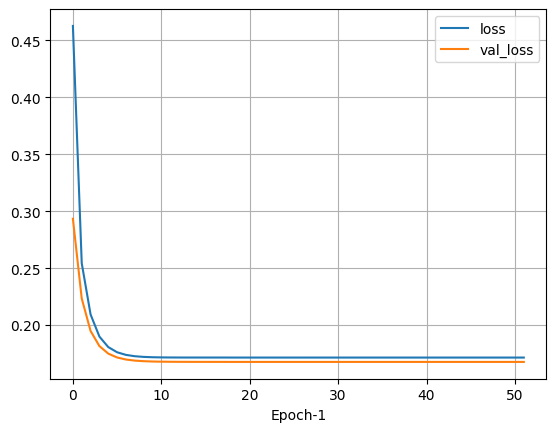

In [14]:
# Preprocessing: Make everything numeric, then scale
preprocessor = make_pipeline(prep_lgb, StandardScaler()).fit(X_train)

# Things that should be done during training
callbacks = [
    keras.callbacks.EarlyStopping(patience=20),
    keras.callbacks.ReduceLROnPlateau(patience=5),
]


def make_glm():
    """Mimic a GLM"""
    tf.random.set_seed(4)

    inputs = keras.Input(shape=(X_train.shape[1],))
    outputs = layers.Dense(1, activation="exponential")(inputs)

    return keras.Model(inputs=inputs, outputs=outputs)


# Create, compile and fit model
keras_model = make_glm()
keras_model.summary()

keras_model.compile(
    loss="poisson",
    optimizer=keras.optimizers.Adam(learning_rate=0.02),
    weighted_metrics=[],
)

history = keras_model.fit(
    x=preprocessor.transform(X_train),
    y=y_train,
    sample_weight=w_train,
    epochs=100,
    batch_size=10_000,
    validation_split=0.2,  # always takes last 20% of rows of train
    callbacks=callbacks,
    verbose=0,
)

_ = pd.DataFrame(history.history).filter(like="loss").plot(xlabel="Epoch-1", grid=True)

In [15]:
# Combine to Scikit-Learn like model
model = KerasRegressor(make_pipeline(preprocessor, keras_model))

GLM


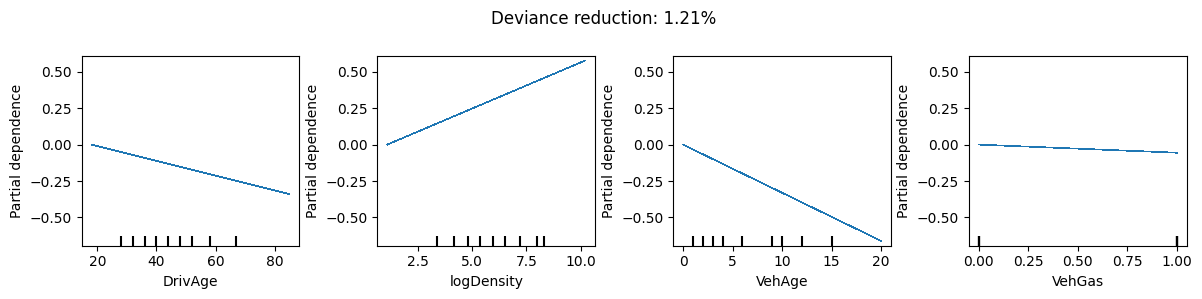

In [16]:
# Compare against traditinonal GLM
print("GLM")
summary_model(model_glm, ref_model=ref_model)

Neural net


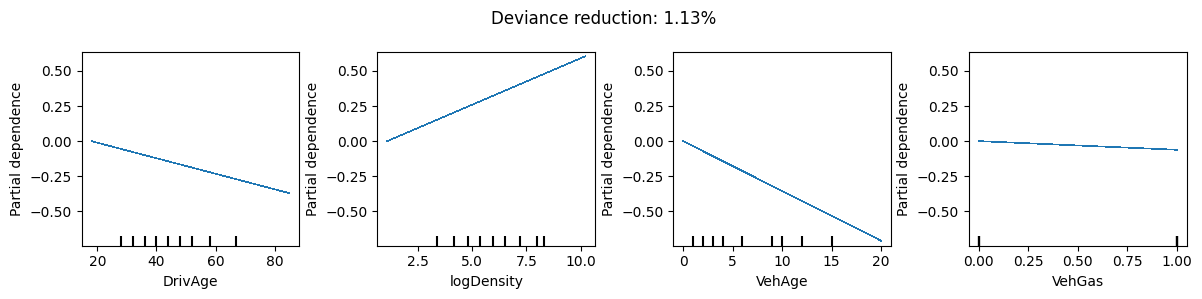

In [17]:
print("Neural net")
summary_model(model, ref_model=ref_model)

**Comments:**

- It worked: The resulting model seems to be indeed a generalized linear model.
- The performance on the test data is slightly lower compared to the original GLM. This may be due to several reasons: First, for simplicity, we represented each feature by a linear function, including some factor variables. Second, the parameters were fitted to only 80% of the training observations. Third, we used gradient descent to fit the parameters, which is a very simple optimization algorithm.

## More complex models

While it is great that a neural network can be used to fit a GLM, its strength lies in its *hidden layers*. The nodes on these hidden layers are latent variables that represent the original input features in a way that optimally predicts the response. The closer a hidden layer is to the output, the more optimal this representation is. This is referred to as *representational learning*: The neural network automatically learns relevant nonlinearities and interaction effects that would have to be added manually in a GLM. For this to work, you need a sufficiently flexible architecture (the layers and their nodes) and enough observations. 

An important component are the *activation functions* placed after each hidden layer. They transform the weighted sum of each hidden node non-linearly, thus introducing interaction effects. Typical activation functions are the rectangular linear unit $\text{ReLU}(x) = \text{max}(0, x)$, the standard logistic function ("sigmoid") and the nearly identical hyperbolic tangent. The activation function applied to the output node has a different purpose: it maps the network output to the scale of the response, just like the inverse link function in a GLM. A neural network without activation functions could only represent a linear function of the inputs, regardless of how many hidden layers the model has (why?).

### Example: A "complex" neural net

We will now modify our GLM neural network by adding three hidden layers to the model, resulting in a model with 561 parameters. Typically, the first hidden layer has more nodes than input features ("feature explosion"), after which the number of nodes shrinks again.

On the one hand, the model needs a large number of parameters to be flexible enough. On the other hand, too many parameters lead to overfitting. For tabular data, a healthy ratio of rows per parameter is somewhere between 50 and 200. When working with unstructured data, different rules apply.

In Scheme 4b, we use only one hidden layer to not overload the image.

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           315 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 561 (2.19 KB)

 Trainable params: 561 (2.19 KB)

 Non-trainable params: 0 (0.00 B)

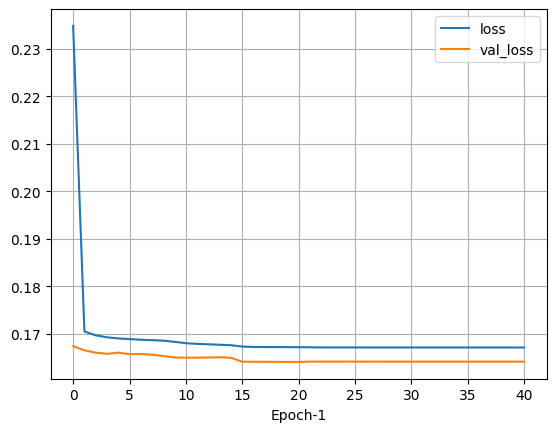

In [18]:
def make_full_nn():
    """Architecture of neural network with hidden layers"""
    tf.random.set_seed(4)

    inputs = keras.Input(shape=(X_train.shape[1],))
    x = layers.Dense(20, activation="tanh")(inputs)
    x = layers.Dense(15, activation="tanh")(x)
    x = layers.Dense(5, activation="tanh")(x)
    outputs = layers.Dense(1, activation="exponential")(x)

    return keras.Model(inputs=inputs, outputs=outputs)


# Create, compile and fit model
keras_model = make_full_nn()
keras_model.summary()  # 561 parameters

keras_model.compile(
    loss="poisson",
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    weighted_metrics=[],
)

history = keras_model.fit(
    x=preprocessor.transform(X_train),
    y=y_train,
    sample_weight=w_train,
    epochs=100,
    batch_size=10_000,
    validation_split=0.2,  # always takes last 20% of rows of train
    callbacks=callbacks,
    verbose=0,
)

_ = pd.DataFrame(history.history).filter(like="loss").plot(xlabel="Epoch-1", grid=True)

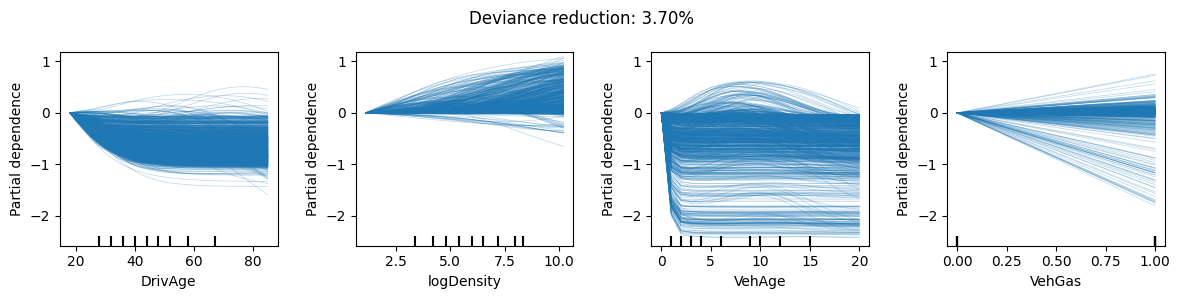

In [19]:
model = KerasRegressor(make_pipeline(preprocessor, keras_model))
summary_model(model, ref_model=ref_model)

**Comments:**

- The ICE plots show very wild and non-linear effects with strong interactions. Thus, the hidden layers indeed care about feature representation in a fully automatic way. This is in contrast to classical GLMs where such transformations have to be added manually.
- The performance is considerably superior to the GLM, but still lower than the boosted trees model.

## Additive neural nets

In the first two examples on neural nets we have seen that we can use them to fit linear additive models as well as a typical black box. Thanks to the flexibility of neural networks, we can also use them to build GAMs. In such a "neural additive model" (<a href="#ref-agarwal2020">Agarwal et al. 2020</a>), each feature $X^{(j)}$ is sent through a small single-output neural network that represents $X^{(j)}$ as a non-linear smooth function. The outputs of these sub-networks are then directly connected to the output node to avoid interaction effects, see Scheme 5 (a):

<img src="https://www.mdpi.com/jrfm/jrfm-15-00193/article_deploy/html/images/jrfm-15-00193-g001.png" width="80%"/>

Scheme 5: (a) Neural additive model, (b) partly additive neural net, source: Figure 1 in https://www.mdpi.com/1911-8074/15/5/193.

Note that some components can also be represented linearly, i.e., without sub-network. Furthermore, note that unordered factors in neural networks are generally represented either by one-hot-encoded binary variables or by a so-called *embedding layer*. An embedding layer transforms an integer encoded factor to one (or more) numeric features.

### Example

We will now build a neural additive model with three different types of inputs:

- "VehBrand" and "PolicyRegion": Integer encoded and represented by a 1-dimensional embedding layer each.
- "VehGas" and "logDensity": Scaled and represented by a linear function each. ("VehGas" is binary, so scaling would not be necessary.)
- "VehAge", "DrivAge", and "VehPower": Scaled and represented by a small neural network each.

The implied structure is similar to our classic GAM.

Normally, a statistical model requires a single data matrix for training. A neural network, like the one described here, is more flexible. In the following example, we will pass each feature as a single-column matrix. In the same way, we could build a neural network with mixed input such as images, text, and numbers.

In [20]:
x_num = ["VehPower", "VehAge", "VehGas", "DrivAge", "logDensity"]
x_cat = ["VehBrand", "PolicyRegion"]

# Scale numerics, ordinal encode embedding features
neural_net_trafo = ColumnTransformer(
    transformers=[
        ("numeric", StandardScaler(), x_num),
        ("embedding", OrdinalEncoder(), x_cat),  # no scaling!
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

# Split columns to dict
preprocessor = Pipeline(
    steps=[
        ("transform", neural_net_trafo),
        ("split", ColumnSplitter({x: [x] for x in xvars})),
    ]
)
preprocessor.fit(X_train)
preprocessor.transform(X_train.head(2))

{'VehPower': array([[-0.21859688],
        [-0.21859688]]),
 'VehAge': array([[-0.92247857],
        [-0.73706365]]),
 'VehGas': array([[1.02008511],
        [1.02008511]]),
 'DrivAge': array([[ 0.74433362],
        [-0.24762245]]),
 'logDensity': array([[ 0.33552732],
        [-1.41536892]]),
 'VehBrand': array([[2.],
        [3.]]),
 'PolicyRegion': array([[2.],
        [1.]])}

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ VehAge (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DrivAge             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ VehPower            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ VehBrand            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PolicyRegion        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 8)         │         16 │ VehAge[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 7)         │         14 │ DrivAge[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 3)         │          6 │ VehPower[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 1)      │          4 │ VehBrand[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 1)      │          6 │ PolicyRegion[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ VehGas (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logDensity          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │          9 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │          8 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │          4 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7)         │          0 │ VehGas[0][0],     │
│ (Concatenate)       │                   │            │ logDensity[0][0], │
│                     │                   │            │ dense_10[0][0],   │
│                     │                   │            │ dense_6[0][0],    │
│                     │                   │            │ dense_8[0][0],    │
│                     │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 75 (300.00 B)

 Trainable params: 75 (300.00 B)

 Non-trainable params: 0 (0.00 B)

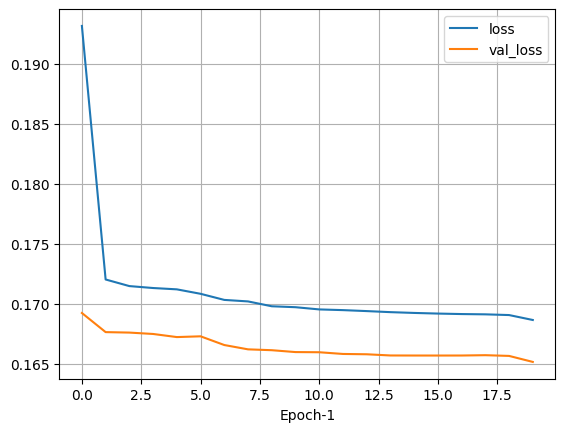

In [21]:
def make_additive_nn():
    """Neural additive model

    Note that the code be written more compactly.
    """
    tf.random.set_seed(4)

    # Linear logDensity and VehGas
    logDensity_input = keras.Input((1,), name="logDensity")
    VehGas_input = keras.Input((1,), name="VehGas")

    # Smooth DrivAge, VehPower, VehAge
    DrivAge_input = keras.Input((1,), name="DrivAge")
    x = layers.Dense(7, activation="tanh")(DrivAge_input)
    DrivAge_smooth = layers.Dense(1)(x)

    VehPower_input = keras.Input((1,), name="VehPower")
    x = layers.Dense(3, activation="tanh")(VehPower_input)
    VehPower_smooth = layers.Dense(1)(x)

    VehAge_input = keras.Input((1,), name="VehAge")
    x = layers.Dense(8, activation="tanh")(VehAge_input)
    VehAge_smooth = layers.Dense(1)(x)

    # 1d embeddings
    m_PolicyRegion = X_train["PolicyRegion"].nunique()
    PolicyRegion_input = keras.Input((1,), name="PolicyRegion")
    x = layers.Embedding(m_PolicyRegion, output_dim=1)(PolicyRegion_input)
    PolicyRegion_emb = layers.Flatten()(x)

    m_VehBrand = X_train["VehBrand"].nunique()
    VehBrand_input = keras.Input((1,), name="VehBrand")
    x = layers.Embedding(m_VehBrand, output_dim=1)(VehBrand_input)
    VehBrand_emb = layers.Flatten()(x)

    # Combine all pieces
    to_concatenate = [
        VehGas_input,
        logDensity_input,
        VehAge_smooth,
        DrivAge_smooth,
        VehPower_smooth,
        VehBrand_emb,
        PolicyRegion_emb,
    ]
    x = layers.Concatenate()(to_concatenate)
    outputs = layers.Dense(1, activation="exponential")(x)

    inputs = {
        "logDensity": logDensity_input,
        "VehGas": VehGas_input,
        "DrivAge": DrivAge_input,
        "VehPower": VehPower_input,
        "VehAge": VehAge_input,
        "PolicyRegion": PolicyRegion_input,
        "VehBrand": VehBrand_input,
    }
    return keras.Model(inputs=inputs, outputs=outputs)


# Create, compile and fit model
keras_model = make_additive_nn()
keras_model.summary()  # 75 parameters

keras_model.compile(
    loss="poisson",
    optimizer=keras.optimizers.Adam(learning_rate=0.1),
    weighted_metrics=[],
)

history = keras_model.fit(
    x=preprocessor.transform(X_train),
    y=y_train,
    sample_weight=w_train,
    epochs=100,
    batch_size=10_000,
    validation_split=0.2,  # always takes last 20% of rows of train
    callbacks=callbacks,
    verbose=0,
)

_ = pd.DataFrame(history.history).filter(like="loss").plot(xlabel="Epoch-1", grid=True)

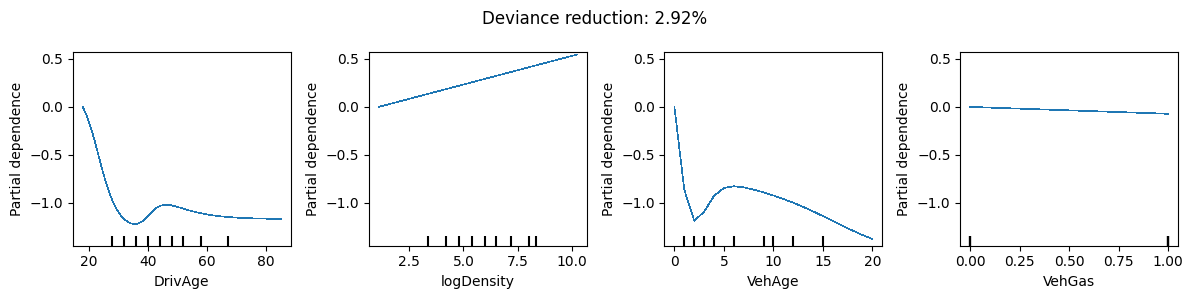

In [22]:
model = KerasRegressor(make_pipeline(preprocessor, keras_model))
summary_model(model, ref_model=ref_model)

**Comments:**

- The resulting model performs quite similar to the classic GAM, and slightly worse than the additive boosted trees model.
- According to the c-ICE plots, the model structure seems to be as desired.
- To create a structured neural network, one usually needs many lines of code.

## Partly additive neural nets

Our last neural network was additive in all features. If we wanted to add pairwise interactions, we could simply use a neural network with a single hidden layer. But what if we wanted to create a partly additive model that kept driver-related effects additive while allowing vehicle variables to interact? Several architectures would provide such a model, see Scheme 5 (b) for a sketch of the idea, and Mayer et al. (<a href="#ref-mayer2022">2022</a>) for a use case in geographic modeling.

### Example

In order to create a model as outlined above, we will directly connect the following components to the output layer, producing an additive model in each of the components:

- "logDensity": Scaled and represented as a linear function.
- "DrivAge": Scaled and represented by a small sub-network.
- "PolicyRegion": Integer encoded and represented by a one-dimensional embedding.
- Vehicle features are represented by a sub-network with five output nodes. "VehBrand" enters the sub-network via an embedding layer.

In [23]:
split_dict = {
    "logDensity": ["logDensity"],
    "DrivAge": ["DrivAge"],
    "PolicyRegion": ["PolicyRegion"],
    "VehBrand": ["VehBrand"],
    "other_vehicle": ["VehPower", "VehAge", "VehGas"],
}

# Split columns to dict
preprocessor = Pipeline(
    steps=[
        ("transform", neural_net_trafo),
        ("split", ColumnSplitter(split_dict)),
    ]
)
preprocessor.fit(X_train)
preprocessor.transform(X_train.head(2))

{'logDensity': array([[ 0.33552732],
        [-1.41536892]]),
 'DrivAge': array([[ 0.74433362],
        [-0.24762245]]),
 'PolicyRegion': array([[2.],
        [1.]]),
 'VehBrand': array([[2.],
        [3.]]),
 'other_vehicle': array([[-0.21859688, -0.92247857,  1.02008511],
        [-0.21859688, -0.73706365,  1.02008511]])}

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ VehBrand            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 1)      │          4 │ VehBrand[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 1)         │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ other_vehicle       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4)         │          0 │ flatten_3[0][0],  │
│ (Concatenate)       │                   │            │ other_vehicle[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DrivAge             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PolicyRegion        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 15)        │         75 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 7)         │         14 │ DrivAge[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 1)      │          6 │ PolicyRegion[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 10)        │        160 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logDensity          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │          8 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1)         │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 5)         │         55 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8)         │          0 │ logDensity[0][0], │
│ (Concatenate)       │                   │            │ dense_13[0][0],   │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │          9 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 331 (1.29 KB)

 Trainable params: 331 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

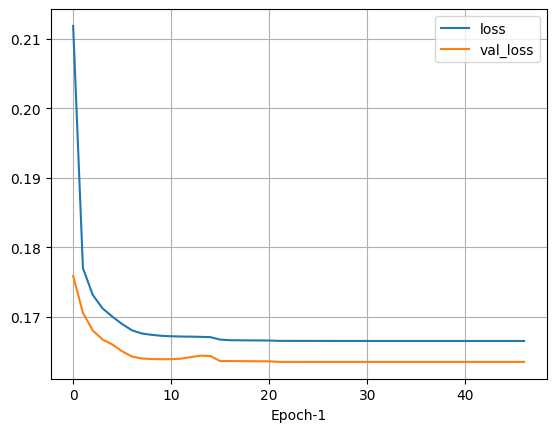

In [24]:
def make_partly_additive_nn():
    """Partly additive neural net"""
    tf.random.set_seed(16)

    # Linear logDensity
    logDensity_input = keras.Input((1,), name="logDensity")

    # Smooth DrivAge
    DrivAge_input = keras.Input((1,), name="DrivAge")
    x = layers.Dense(7, activation="tanh")(DrivAge_input)
    DrivAge_smooth = layers.Dense(1)(x)

    # PolicyRegion embedding
    m_PolicyRegion = X_train["PolicyRegion"].nunique()
    PolicyRegion_input = keras.Input((1,), name="PolicyRegion")
    x = layers.Embedding(m_PolicyRegion, output_dim=1)(PolicyRegion_input)
    PolicyRegion_emb = layers.Flatten()(x)

    # Inputs with interactions among them
    other_vehicle_input = keras.Input((3,), name="other_vehicle")

    m_VehBrand = X_train["VehBrand"].nunique()
    VehBrand_input = keras.Input((1,), name="VehBrand")
    x = layers.Embedding(m_VehBrand, output_dim=1)(VehBrand_input)
    VehBrand_emb = layers.Flatten()(x)

    # Define vehicle subnet
    x = layers.Concatenate()([VehBrand_emb, other_vehicle_input])
    x = layers.Dense(15, activation="tanh")(x)
    x = layers.Dense(10, activation="tanh")(x)
    veh_subnet = layers.Dense(5)(x)

    # Concatenate additive components with subset and directly connect with output
    x = layers.Concatenate()(
        [logDensity_input, DrivAge_smooth, PolicyRegion_emb, veh_subnet]
    )
    outputs = layers.Dense(1, activation="exponential")(x)

    inputs = {
        "logDensity": logDensity_input,
        "DrivAge": DrivAge_input,
        "PolicyRegion": PolicyRegion_input,
        "VehBrand": VehBrand_input,
        "other_vehicle": other_vehicle_input,
    }

    return keras.Model(inputs=inputs, outputs=outputs)


# Create, compile and fit model
keras_model = make_partly_additive_nn()
keras_model.summary()  # 331 parameters

keras_model.compile(
    loss="poisson",
    optimizer=keras.optimizers.Adam(learning_rate=0.02),
    weighted_metrics=[],
)

history = keras_model.fit(
    x=preprocessor.transform(X_train),
    y=y_train,
    sample_weight=w_train,
    epochs=100,
    batch_size=10_000,
    validation_split=0.2,  # always takes last 20% of rows of train
    callbacks=callbacks,
    verbose=0,
)

_ = pd.DataFrame(history.history).filter(like="loss").plot(xlabel="Epoch-1", grid=True)

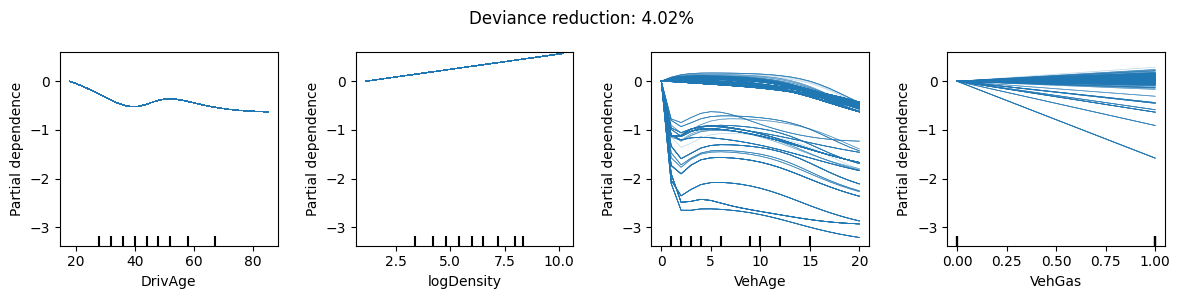

In [25]:
model = KerasRegressor(make_pipeline(preprocessor, keras_model))
summary_model(model, ref_model=ref_model)

**Comments:**

- Compared to the neural additive model, "VehAge" (and also the other vehicle-related variables) incorporates interaction effects with other vehicle characteristics. The driver characteristics remain additive.
- Since some of the interaction effects are strong, the performance of the model has greatly improved compared to the neural additive model. Its performance is even slightly higher than the one of the unconstrained model.
- The performance is lower than that of the corresponding boosted trees model with interaction constraints. The difference might be explained by the fact that the neural network effects are smooth and "logDensity" is represented linearly.

# Excursion: Tuning Boosted Trees

Hyperparameters of ML models (including GLMs) are usually selected or *tuned* by the help of train/test splits and (cross-)validation. However, each model class (GLMs, GAMs, random forests, boosted trees, neural nets, ...) has its own peculiarities and subtleties that should be respected. In this section, we will learn how to tune the many hyperparameters of a boosted trees model, such as the objective, the learning rate, the number of trees (= boosting rounds), and further regularization parameters. We will closely follow the suggestions in Chapter "Trees" in Mayer (<a href="#ref-mayer2021ml">2021</a>). It would be naive and irresponsible to use a completely untuned boosted trees model.

Our focus is on boosted trees, as they are usually among the most powerful modeling techniques for tabular data. In addition, we have learned the elegant workflow to build a strong GLM by analyzing such a model with SHAP.

## Objective and metric

The first decision is to select a meaningful and ideally strictly consistent scoring/loss function for the distributional property $T$. On this basis, the evaluation metric and the objective are determined. The objective is used to *fit* the model, while the evaluation metric is used for model evaluation and parameter selection.

Examples:

- For pricing models of expected claims frequency and claims severity, one typically uses the corresponding deviance as (strictly consistent) scoring function. The average deviance then serves as both the objective and the evaluation metric.
- In many other regression situations for $T = \mathbb E$, one uses the squared error as strictly consistent loss function. The corresponding objective is the mean squared error (MSE), and the evaluation metric is either the MSE or its root (RMSE).
- When $T$ is the median, the absolute error $L(z, y) = |y-z|$ is a strictly consistent scoring function. Its mean then serves as natural evaluation metric and objective.

## Number of boosting rounds

Selecting an appropriate number of boosting rounds/trees is important: too few rounds tend to underfitting, while too many will often cause overfitting. A convenient strategy, called *early stopping*, is to calculate the evaluation metric after each boosting round by (cross-)validation. Once performance stops improving over a certain number of rounds, the boosting process is stopped. This approach is particularly useful because a good number of boosting rounds depends strongly on the choice of the other parameters, e.g., the learning rate. Thus, randomly selecting the number of boosting rounds along with the other parameters would often lead to a suboptimal solution.

## Learning rate

The learning rate equals the weight of each tree in the final model. Its value (often between 1 and 0.005) can be chosen manually to achieve a reasonable number of boosting rounds by early stopping, aiming for a number between 100 and 1000 trees. Fewer trees will result in too simple a model, while more trees require long to fit. To quickly find a good learning rate, take advantage of the rule that dividing the learning rate by two roughly doubles the number of boosting rounds required for comparable performance. For instance, if you start with a learning rate of 0.2 and the model stops early already after only 50 rounds, you might try out a learning rate of 0.05 and expect a model that stops at about 200 trees (and hopefully performs slightly better).

## Regularization parameters

Implementations of gradient boosted trees typically offer many parameters to control the size of the trees and other aspects of boosting, e.g., 

- the number of leaf nodes,
- the tree depth,
- loss penalties,
- row and column subsampling rates,
- minimal leaf size,
- minimal loss improvement to make another split etc. 

These parameters are either selected one by one using (cross-)validation or by randomized grid search. There, many random parameter combinations are evaluated and one typically selects the combination with the best (cross-)validation performance.

Note: The number of boosting rounds picked by early stopping often compensates for a suboptimal choice of other parameters. In fact, most parameters are highly interdependent in the sense that different parameter combinations can result in similar model performance.

## Strategy

To sum up, a simple strategy for selecting good parameters for a boosted trees model is as follows:

1. Start by selecting a meaningful and ideally strictly consistent loss function for the functional $T$ of the response. This determines the objective and the evaluation metric.
2. Choose the learning rate to produce a model with about 100 to 1000 trees, with early stopping by (cross-)validation.
3. Select the other parameters manually or by random search using (cross-)validation.

Often the performance improvements from Step 3 are modest, so this part can sometimes be skipped, especially when working with large data.

## Example: French MTPL (LightGBM)

How did we select the hyperparameters of the LightGBM model fitted on claims frequencies of the French MTPL data?

The initial step was to choose the Poisson deviance as loss function (strictly consistent for the expectation), determining both the objective and evaluation metric. The other steps are summarized in the code below. Compared to a standard LightGBM tuning workflow, we passed our own (grouped) cross-validation folds to `lgb.cv()`.

In [26]:
# Rerunning takes ~30 mins; results might depend on seed. We list all required modules
import json
from pathlib import Path

import lightgbm as lgb
import pandas as pd
from joblib import load
from lightgbm import LGBMRegressor
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline

main = Path("french_motor")
grid_file = main / "grid_base_lgb.txt"

train, test, X_train, X_test, y_train, y_test, w_train, w_test, xvars, prep_lgb = load(
    main / "data.joblib"
)

# Data interface of LightGBM
dtrain = lgb.Dataset(
    prep_lgb.fit_transform(X_train),
    label=y_train,
    weight=w_train,
    params={"feature_pre_filter": False},
)

# STEP 1: Model for expected claims frequency -> Poisson deviance

# STEP 2: Select learning rate so that optimal number of rounds by early stopping is
# somewhere between 100 and 1000
params = {
    "objective": "poisson",
    "learning_rate": 0.05,
    "verbose": -1,  # play with learning_rate
}

In [27]:
# k-fold grouped cross-validation to see how many trees are required by early stopping
folds = list(GroupKFold(n_splits=5).split(X=X_train, groups=train.group_id))

cvm = lgb.cv(
    params=params,
    train_set=dtrain,
    num_boost_round=5000,
    folds=folds,
    # nfold = 5,  # for the ungrouped case, plus stratified=False,
    eval_train_metric=True,
    callbacks=[lgb.log_evaluation(period=0), lgb.early_stopping(20, verbose=0)],
)

# A LR of 0.05 provides about 300 trees, which is convenient
cvm = pd.DataFrame(cvm)
print("Best boosting round with default params:\n", len(cvm))
cvm.tail(1)

Best boosting round with default params:
 331


,train poisson-mean,train poisson-stdv,valid poisson-mean,valid poisson-stdv
330,0.304321,0.000861,0.31158,0.003309


In [28]:
# STEP 3: Iterate randomized SearchCV for regularization parameters
if False:
    # Or ParameterGrid(...) if grid is small enough to check all combinations
    grid = ParameterSampler(
        {
            "objective": ["poisson"],
            "learning_rate": [0.05],
            "num_leaves": [15, 31, 63],
            "reg_lambda": [0, 2.5, 5, 7.5],
            "reg_alpha": [0, 4],
            "colsample_bynode": [0.8, 1],
            "subsample": [0.8, 1],
            "min_child_samples": [20, 50, 100],
            "poisson_max_delta_step": [0.1, 0.7],
            "verbose": [-1],
        },
        n_iter=50,
        random_state=94,
    )

    # Iterate over grid and save relevant information on disk
    search = []
    for g in tqdm(grid):
        cvm = lgb.cv(
            params=g,
            train_set=dtrain,
            num_boost_round=5000,
            # nfold = 5,  # for the ungrouped case, plus stratified=False,
            folds=folds,
            seed=82,
            eval_train_metric=True,
            callbacks=[lgb.log_evaluation(period=0), lgb.early_stopping(20, verbose=0)],
        )
        # Keep number of rounds, cv score, train score, and parameters
        cvm = pd.DataFrame(cvm)
        search.append((len(cvm), *cvm.iloc[-1, [2, 0]], g))

        with open(grid_file, "w") as f:
            json.dump(search, f)

# Load grid and check (A) sort order and (B) if grid ranges were set reasonable
with open(grid_file) as f:
    search = json.load(f)

search_df = pd.DataFrame.from_records(
    search, columns=["num_boost_round", "cv_score", "train_score", "params"]
).sort_values("cv_score")

with pd.option_context("display.max_colwidth", None):
    display(search_df.head())

,num_boost_round,cv_score,train_score,params
45,209,0.311422,0.304033,"{'verbose': -1, 'subsample': 1, 'reg_lambda': 5, 'reg_alpha': 0, 'poisson_max_delta_step': 0.7, 'objective': 'poisson', 'num_leaves': 63, 'min_child_samples': 50, 'learning_rate': 0.05, 'colsample_bynode': 0.8}"
18,271,0.311431,0.302943,"{'verbose': -1, 'subsample': 1, 'reg_lambda': 7.5, 'reg_alpha': 0, 'poisson_max_delta_step': 0.7, 'objective': 'poisson', 'num_leaves': 63, 'min_child_samples': 100, 'learning_rate': 0.05, 'colsample_bynode': 0.8}"
19,254,0.311455,0.303199,"{'verbose': -1, 'subsample': 0.8, 'reg_lambda': 7.5, 'reg_alpha': 0, 'poisson_max_delta_step': 0.7, 'objective': 'poisson', 'num_leaves': 63, 'min_child_samples': 50, 'learning_rate': 0.05, 'colsample_bynode': 1}"
23,299,0.311457,0.303137,"{'verbose': -1, 'subsample': 1, 'reg_lambda': 2.5, 'reg_alpha': 0, 'poisson_max_delta_step': 0.1, 'objective': 'poisson', 'num_leaves': 31, 'min_child_samples': 20, 'learning_rate': 0.05, 'colsample_bynode': 0.8}"
49,372,0.311470,0.305085,"{'verbose': -1, 'subsample': 1, 'reg_lambda': 2.5, 'reg_alpha': 0, 'poisson_max_delta_step': 0.7, 'objective': 'poisson', 'num_leaves': 31, 'min_child_samples': 50, 'learning_rate': 0.05, 'colsample_bynode': 0.8}"


In [29]:
# Best parameters
best = search_df.iloc[0]
best.num_boost_round, best.params

(209,
 {'verbose': -1,
  'subsample': 1,
  'reg_lambda': 5,
  'reg_alpha': 0,
  'poisson_max_delta_step': 0.7,
  'objective': 'poisson',
  'num_leaves': 63,
  'min_child_samples': 50,
  'learning_rate': 0.05,
  'colsample_bynode': 0.8})

In [30]:
# Fit on best parameters
lgbr = LGBMRegressor(**best.params, n_estimators=best.num_boost_round, random_state=59)
model_lgb = Pipeline([("preprocessor", prep_lgb), ("model", lgbr)])
_ = model_lgb.fit(X=X_train, y=y_train, model__sample_weight=w_train)

## Australian car claims (XGBoost)

In the exercises, we have worked with XGBoost to model expected Australian car claims frequencies. Here is the full code that was originally used to find the proposed parameter combination of the model used, e.g., in the exercises of Chapter 1.

In [31]:
# Rerunning takes ~10 mins; results might depend on seed. We reimport necessary modules
import json
from pathlib import Path

import pandas as pd
import xgboost as xgb
from joblib import load
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

main = Path("australian_car")
grid_file = main / "grid_xgb.txt"

# Data splits and more already prepared in Chapter 1 exercises (must run first)
X_train, X_test, y_train, y_test, w_train, w_test, xvars, prep_tree = load(
    main / "data.joblib"
)

# Data interface of XGBoost
dtrain = xgb.DMatrix(prep_tree.fit_transform(X_train), label=y_train, weight=w_train)

# STEP 1: Model for the expected claims frequency
# -> Poisson deviance is both strictly consistent and meaningful

# STEP 2: Select learning rate to get reasonable number of trees by early stopping
params = {
    "objective": "count:poisson",
    "learning_rate": 0.05,  # play with learning_rate
}

In [32]:
# k-fold cross-validation to see if number of trees is reasonable
cvm = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    nfold=5,
    early_stopping_rounds=20,
    callbacks=[xgb.callback.EvaluationMonitor(period=50)],
)

# A LR of 0.05 provides about 150 trees, which is quite low, but ok
print("Best boosting round with default params:\n")
cvm.tail(1)

[0]	train-poisson-nloglik:0.77572	test-poisson-nloglik:0.77580
[50]	train-poisson-nloglik:0.54280	test-poisson-nloglik:0.54724
[100]	train-poisson-nloglik:0.50092	test-poisson-nloglik:0.51149
[150]	train-poisson-nloglik:0.49206	test-poisson-nloglik:0.50817
[173]	train-poisson-nloglik:0.49002	test-poisson-nloglik:0.50843
Best boosting round with default params:



,train-poisson-nloglik-mean,train-poisson-nloglik-std,test-poisson-nloglik-mean,test-poisson-nloglik-std
153,0.491781,0.004099,0.508163,0.016359


In [33]:
# STEP 3: Iterate randomized SearchCV for regularization parameters
if False:
    # Or ParameterGrid(...) if grid is small enough to check all combinations
    grid = ParameterSampler(
        {
            "objective": ["count:poisson"],
            "learning_rate": [0.05],
            "max_depth": [1, 2, 3, 4, 5],
            "colsample_bynode": [0.8, 1],
            "subsample": [0.8, 1],
            "reg_lambda": [0, 1, 2, 3],
            "reg_alpha": [0, 1, 2, 3],
            "min_split_loss": [0, 0.001],
            "max_delta_step": [0.1, 0.7],
        },
        n_iter=50,
        random_state=9,
    )

    # Iterate over grid and save relevant information on disk
    search = []
    for g in tqdm(grid):
        cvm = xgb.cv(
            params=g,
            dtrain=dtrain,
            num_boost_round=5000,
            nfold=5,
            seed=67,
            early_stopping_rounds=20,
        )
        # Keep number of rounds, cv score, train score, and parameters
        search.append((len(cvm), *cvm.iloc[-1, [2, 0]], g))

        with open(grid_file, "w") as f:
            json.dump(search, f)

# Load grid and check (A) sort order and (B) if grid ranges were set reasonable
with open(grid_file) as f:
    search = json.load(f)

search_df = pd.DataFrame.from_records(
    search, columns=["num_boost_round", "cv_score", "train_score", "params"]
).sort_values("cv_score")

with pd.option_context("display.max_colwidth", None):
    display(search_df.head())

,num_boost_round,cv_score,train_score,params
17,292,0.505266,0.504092,"{'subsample': 1, 'reg_lambda': 2, 'reg_alpha': 1, 'objective': 'count:poisson', 'min_split_loss': 0.001, 'max_depth': 2, 'max_delta_step': 0.1, 'learning_rate': 0.05, 'colsample_bynode': 0.8}"
10,298,0.505298,0.504053,"{'subsample': 1, 'reg_lambda': 3, 'reg_alpha': 2, 'objective': 'count:poisson', 'min_split_loss': 0.001, 'max_depth': 2, 'max_delta_step': 0.1, 'learning_rate': 0.05, 'colsample_bynode': 1}"
32,371,0.505315,0.504565,"{'subsample': 0.8, 'reg_lambda': 3, 'reg_alpha': 0, 'objective': 'count:poisson', 'min_split_loss': 0, 'max_depth': 1, 'max_delta_step': 0.1, 'learning_rate': 0.05, 'colsample_bynode': 0.8}"
5,371,0.505316,0.504565,"{'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'objective': 'count:poisson', 'min_split_loss': 0, 'max_depth': 1, 'max_delta_step': 0.1, 'learning_rate': 0.05, 'colsample_bynode': 0.8}"
40,331,0.505320,0.503641,"{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'objective': 'count:poisson', 'min_split_loss': 0.001, 'max_depth': 2, 'max_delta_step': 0.1, 'learning_rate': 0.05, 'colsample_bynode': 0.8}"


In [34]:
# Best parameters
best = search_df.iloc[0]
best.num_boost_round, best.params

(292,
 {'subsample': 1,
  'reg_lambda': 2,
  'reg_alpha': 1,
  'objective': 'count:poisson',
  'min_split_loss': 0.001,
  'max_depth': 2,
  'max_delta_step': 0.1,
  'learning_rate': 0.05,
  'colsample_bynode': 0.8})

In [35]:
# Fit on best parameters
xgbr = XGBRegressor(**best.params, n_estimators=best.num_boost_round, random_state=59)
model_xgb = Pipeline([("preprocessor", prep_tree), ("model", xgbr)])
_ = model_xgb.fit(X=X_train, y=y_train, model__sample_weight=w_train)

# Exercises

We use an insurance dataset available from [openML (ID 42876)](https://www.openml.org/d/42876). It was synthetically generated by Colin Priest. The raw data describes 100,000 workers compensation claims regarding ultimate loss (the model response), the initial case estimate (the main predictor), the dates of accident and reporting, demographic information on the worker and finally also a short text describing the accident.

The main aim will be to craft intelligible models predicting the ultimate claim amount per claim. All models should be Gamma regressions with log link.

You can freely do the programming yourself, or use the following code. We will focus on rows with `WeeklyPay >= 200`and `HoursWorkedPerWeek >= 20`.

In [36]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import tensorflow as tf
from joblib import dump
from keras import layers
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.datasets import fetch_openml
from sklearn.dummy import DummyRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import GammaRegressor
from sklearn.metrics import mean_gamma_deviance
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow import keras
from utils import ColumnSplitter, KerasRegressor, LogRegressor, get_coefs

from xgboost import XGBRegressor

# Workers Compensation dataset, see # https://www.openml.org/d/42876
main = Path("workers_compensation/")
df0 = fetch_openml(data_id=42876, parser="pandas").frame

# Data preparation very similar to Christian's code here:
#  https://github.com/actuarial-data-science/Tutorials/blob/master/11%20-%20Model%20Comparison%20and%20Calibration%20Assessment/model_comparison_calibration_ass.ipynb
df = df0.query("WeeklyPay >= 200 and HoursWorkedPerWeek >= 20").assign(
    Ultimate=lambda x: x.UltimateIncurredClaimCost.clip(upper=1e6),
    LogInitial=lambda x: np.log(x.InitialCaseEstimate.clip(1e2, 1e5)),
    LogWeeklyPay=lambda x: np.log(x.WeeklyPay.clip(100, 2000)),
    LogAge=lambda x: np.log(x.Age.clip(17, 70)),
    Female=lambda x: (x.Gender == "F").astype(int),
    Married=lambda x: (x.MaritalStatus == "M").astype(int),
    PartTime=lambda x: (x.PartTimeFullTime == "P").astype(int),
    DateTimeOfAccident=lambda x: pd.to_datetime(x.DateTimeOfAccident),
    DateOfAccident=lambda x: x.DateTimeOfAccident.dt.date,
    DateReported=lambda x: pd.to_datetime(x.DateReported).dt.date,
    LogDelay=lambda x: np.log1p(
        pd.to_timedelta(x.DateReported - x.DateOfAccident).dt.days
    ),
    DateNum=lambda x: x.DateTimeOfAccident.dt.year
    + (x.DateTimeOfAccident.dt.dayofyear - 1) / 365,
    WeekDay=lambda x: x.DateTimeOfAccident.dt.weekday,  # 0 = Monday
    Hour=lambda x: x.DateTimeOfAccident.dt.hour,
)

x_continuous = ["LogInitial", "LogWeeklyPay", "LogDelay", "LogAge", "DateNum"]
x_discrete = ["PartTime", "Female", "Married", "WeekDay", "Hour"]
xvars = x_continuous + x_discrete

df[xvars].head()

,LogInitial,LogWeeklyPay,LogDelay,LogAge,DateNum,PartTime,Female,Married,WeekDay,Hour
0,9.159047,6.214608,2.484907,3.806662,2005.032877,0,0,0,3,9
1,8.006368,5.645447,2.995732,3.688879,1994.739726,0,0,1,2,15
5,6.907755,6.248043,3.688879,3.912023,2002.158904,0,1,0,3,7
7,4.700480,5.298317,2.944439,2.944439,1995.298630,0,0,0,3,14
8,9.179881,6.642487,3.218876,2.944439,2005.016438,0,0,0,4,14


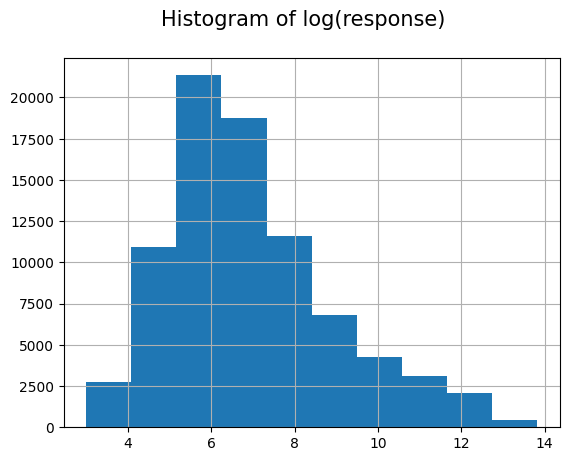

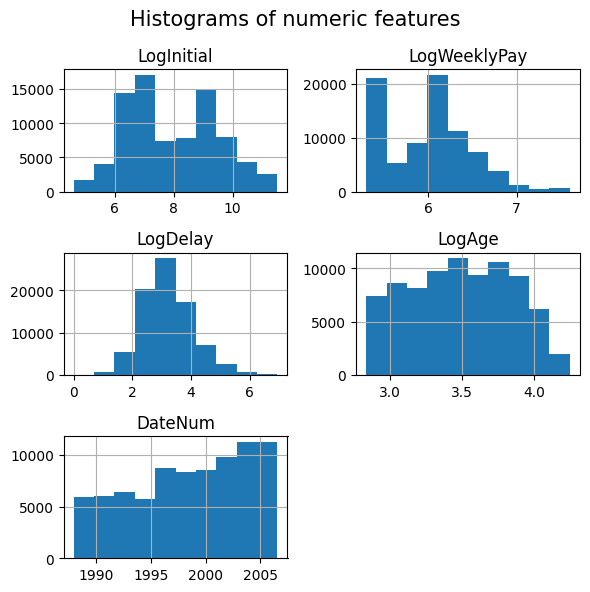

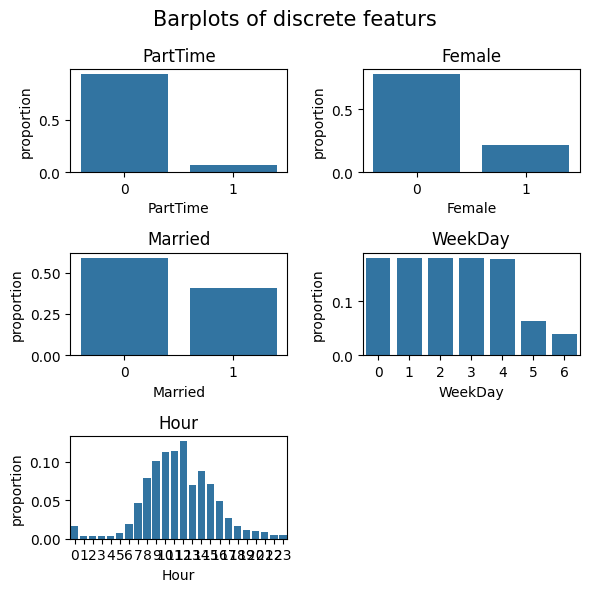

In [37]:
# Univariate distributions of response, continuous and discrete features
np.log(df.Ultimate).hist()
_ = plt.suptitle("Histogram of log(response)", fontsize=15)

df[x_continuous].hist(figsize=(6, 6))
plt.suptitle("Histograms of numeric features", fontsize=15)
plt.tight_layout()

fig, axes = plt.subplots(3, 2, figsize=(6, 6))
fig.suptitle("Barplots of discrete featurs", fontsize=15)

for x, ax in zip(x_discrete, axes.flatten()):
    sns.countplot(data=df, x=x, stat="proportion", ax=ax).set_title(x)
fig.delaxes(axes[2, 1])
fig.tight_layout()

In [38]:
# Train/test split and dump data pieces (have been used to find hyper-parameters below)
X_train, X_test, y_train, y_test = train_test_split(
    df[xvars], df["Ultimate"], test_size=0.2, random_state=70
)
dump((X_train, X_test, y_train, y_test), Path("workers_compensation") / "data.joblib")

# XGBoost parameters for additive model (Exercise 2)
nrounds = 422
params = {
    "objective": "reg:gamma",
    "learning_rate": 0.1,
    "max_depth": 1,
    "reg_lambda": 1,
    "reg_alpha": 1,
    "subsample": 0.8,
    "colsample_bynode": 0.8,
    "min_split_loss": 0.001,
}

# XGBoost parameters for *partly* additive model (Exercise 4)
interaction_constraints = [
    ["DateNum"],
    ["Female"],
    [
        "LogInitial",
        "LogWeeklyPay",
        "LogDelay",
        "LogAge",
        "PartTime",
        "Married",
        "WeekDay",
        "Hour",
    ],
]
nrounds2 = 441
params2 = {
    "objective": "reg:gamma",
    "learning_rate": 0.05,
    "max_depth": 2,
    "interaction_constraints": interaction_constraints,
    "reg_lambda": 3,
    "reg_alpha": 2,
    "subsample": 0.8,
    "colsample_bynode": 0.8,
    "min_split_loss": 0.0,
}

For all models, we will use the features specified in `x_vars`.

1. Classic model
    - i. Create an additive Gamma GLM with log link.
    - ii. Interpret the effect of "LogInitial". 
    - iii. How large is the relative deviance reduction compared to an intercept-only model on the training data?
2. Additive XGBoost model
    - i. Fit an additive XGBoost Gamma regression using the parameters provided above. Note that XGBoost automatically uses a log link when fitting a Gamma model.
    - ii. How much better is its relative deviance gain on the test data compared to the (training) performance of the GLM? 
    - iii. Interpret the effects with a SHAP analysis.
    - iv. Refit the model by forcing "LogWeeklyPay" to have a monotonically non-decreasing effect. What is the impact on the test performance? On the SHAP dependence plot of this variable?
3. Interactions
    - i. Describe in words how to construct a boosted trees model with pairwise interactions.
    - ii. Same question for a neural net.
    - iii. How to construct a boosted trees model that is additive in two variables and has pairwise interactions for the other features?
4. Partly additive XGBoost model
    - i. Fit an XGBoost Gamma regression that is additive in "Female" and "DateNum" and has pairwise interactions for the other variables. Use the parameter combination provided above.
    - ii. Why could a model like this make sense?
    - iii. Compare its relative deviance gain on the test data with the additive model of Exercise 2ii.
    - iv. Study SHAP dependence plots. Does the model have the desired structure?
5. Neural net
    - i. Study the code below that creates an additive Gamma regression with log link.
    Play with its parameters and the architecture. Can you improve the test performance?
    - ii. Optional. Modify the model to be additive for "Female" and "DateNum", but contains interactions for the other variables.
    Inspect the model using c-ICE plots.

In [39]:
# ==========================================
# Neural net of Exercise 5i
# The code above needs to be run first
# ==========================================

# Gamma deviance loss
def loss_gamma(y_true, y_pred):
    return -keras.ops.log(y_true / y_pred) + y_true / y_pred


# Scaling and splitting into feature lists
binary_vars = ["PartTime", "Female", "Married"]
smooth_vars = [v for v in xvars if v not in binary_vars]
split_dict = {v: [v] for v in smooth_vars} | {"binary": binary_vars}

preprocessor = make_pipeline(
    make_column_transformer(
        (StandardScaler(), xvars), verbose_feature_names_out=False
    ).set_output(transform="pandas"),
    ColumnSplitter(split_dict),
)

preprocessor.fit(X_train)
preprocessor.transform(X_train.head(2))

{'LogInitial': array([[-1.4175368 ],
        [ 0.82100009]]),
 'LogWeeklyPay': array([[-1.38094936],
        [-0.27001114]]),
 'LogDelay': array([[ 1.20384487],
        [-1.37980564]]),
 'LogAge': array([[-0.31913285],
        [-1.22225453]]),
 'DateNum': array([[-1.95643742],
        [ 0.41132759]]),
 'WeekDay': array([[-0.79422687],
        [-1.38305194]]),
 'Hour': array([[-2.49445173],
        [ 1.42996205]]),
 'binary': array([[-0.2696364 , -0.52835164, -0.83570966],
        [-0.2696364 , -0.52835164, -0.83570966]])}

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1684.2008 - val_loss: 10.0087 - learning_rate: 0.0500
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6283 - val_loss: 8.2498 - learning_rate: 0.0500
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6970 - val_loss: 6.6145 - learning_rate: 0.0500
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1634 - val_loss: 5.7997 - learning_rate: 0.0500
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2616 - val_loss: 5.0323 - learning_rate: 0.0500
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4893 - val_loss: 4.3837 - learning_rate: 0.0500
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9030 - val_loss: 3.9271 - learning_rate: 0.0500
Epoch 8/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5448 - val_loss: 3.6583 - learning_rate: 0.0500
Epoch 9/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3614 - val_loss: 3.5028 - learning_rate: 0.0500
Epoch 10/200
53

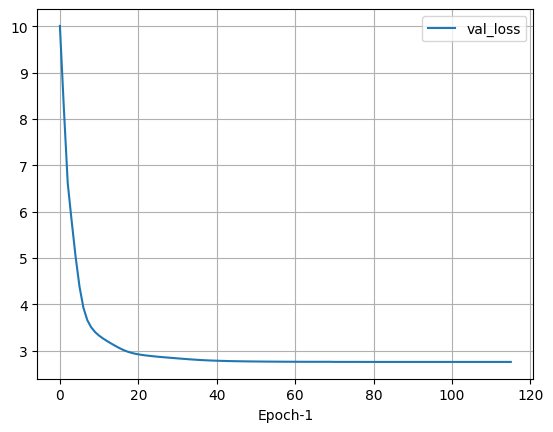

In [40]:
def smoothing_layer(input_layer):
    """Create smoothing layer for input"""
    x = layers.Dense(8, activation="tanh")(input_layer)
    x = layers.Dense(4, activation="tanh")(x)
    return layers.Dense(1)(x)


def make_additive(split_dict):
    """Neural additive model"""
    tf.random.set_seed(4)

    input_dict = {
        name: keras.Input((len(var_list),), name=name)
        for name, var_list in split_dict.items()
    }
    to_concatenate = [
        smoothing_layer(keras_input)
        for name, keras_input in input_dict.items()
        if name in smooth_vars
    ]
    to_concatenate.append(input_dict["binary"])
    x = layers.Concatenate()(to_concatenate)
    outputs = layers.Dense(1, activation="exponential")(x)

    return keras.Model(inputs=input_dict, outputs=outputs)


# Create, compile and fit model
keras_model = make_additive(split_dict)
# keras_model.summary()  # 410 parameters

keras_model.compile(
    loss=loss_gamma, optimizer=keras.optimizers.Adam(learning_rate=0.05)
)

callbacks = [
    keras.callbacks.EarlyStopping(patience=20),
    keras.callbacks.ReduceLROnPlateau(patience=5),
]

history = keras_model.fit(
    x=preprocessor.transform(X_train),
    y=y_train,
    epochs=200,
    batch_size=1000,
    validation_split=0.2,  # always takes last 20% of rows of train
    callbacks=callbacks,
    verbose=1,
)

_ = pd.DataFrame(history.history).filter(like="val").plot(xlabel="Epoch-1", grid=True)

In [41]:
# Interpretation
model = KerasRegressor(make_pipeline(preprocessor, keras_model))

dummy = DummyRegressor().fit(X_train, y_train)

d0, d = (mean_gamma_deviance(y_test, mod.predict(X_test)) for mod in (dummy, model))
print(f"% deviance explained: {(d0 - d) / d0:.2%}")

% deviance explained: 31.72%


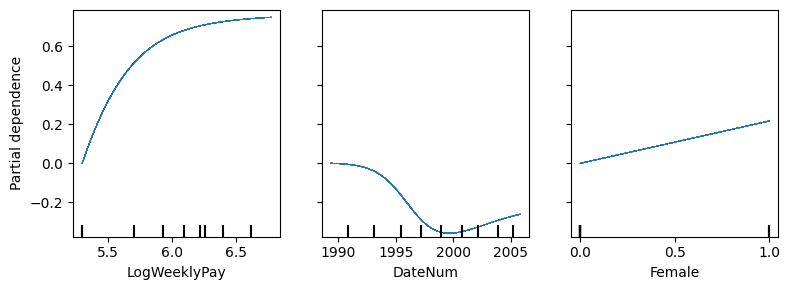

In [42]:
fig, axes = plt.subplots(figsize=(8, 3), layout="tight")

_ = PartialDependenceDisplay.from_estimator(
    LogRegressor(model),
    features=["LogWeeklyPay", "DateNum", "Female"],
    X=X_train.sample(n=1000, random_state=1),
    subsample=100,
    kind="individual",
    centered=True,
    random_state=3,
    ax=axes,
)

# References

<div id="ref-agarwal2020" class="csl-entry">
Agarwal, Rishabh, Nicholas Frosst, Xuezhou Zhang, Rich Caruana, and
Geoffrey E. Hinton. 2020. <span>“Neural Additive Models: Interpretable
Machine Learning with Neural Nets.”</span> <em>CoRR</em> abs/2004.13912.
<a href="https://doi.org/10.48550/arXiv.2004.13912">https://doi.org/10.48550/arXiv.2004.13912</a>.
</div>

<br>
<div id="ref-chollet2017" class="csl-entry">
Chollet, François. 2017. <em>Deep Learning with Python</em>. Manning.
</div>

<br>
<div id="ref-hastie1986" class="csl-entry">
Hastie, Trevor, and Robert Tibshirani. 1986. <span>“<span>Generalized
Additive Models</span>.”</span> <em>Stat. Sci.</em> 1 (3): 297–310. <a href="https://doi.org/10.1214/ss/1177013604">https://doi.org/10.1214/ss/1177013604</a>.
</div>
<div id="ref-hastie1990" class="csl-entry">
———. 1990. <em>Generalized Additive Models</em>. Wiley Online Library.
</div>

<br>
<div id="ref-james2023" class="csl-entry">
James, Gareth, Daniela Witten, Trevor Hastie, Robert Tibshirani, and
Jonathan Taylor. 2023. <em>An Introduction to Statistical Learning with
Applications in Python</em>. Springer Texts in Statistics. Springer. <a href="https://doi.org/10.1007/978-3-031-38747-0">https://doi.org/10.1007/978-3-031-38747-0</a>.
</div>

<br>
<div id="ref-lee2015" class="csl-entry">
Lee, Simon C. K., Sheldon Lin, and Katrien Antonio. 2015. <span>“Delta
Boosting Machine and Its Application in Actuarial Modeling.”</span> In.
Institute of Actuaries of Australia.
</div>

<br>
<div id="ref-lou2012" class="csl-entry">
Lou, Yin, Rich Caruana, and Johannes Gehrke. 2012. <span>“Intelligible
Models for Classification and Regression.”</span> In <em>Proceedings of
the 18th ACM SIGKDD International Conference on Knowledge Discovery and
Data Mining</em>, 150–58. KDD ’12. New York, NY, USA: Association for
Computing Machinery. <a href="https://doi.org/10.1145/2339530.2339556">https://doi.org/10.1145/2339530.2339556</a>.
</div>

<br>
<div id="ref-lundberg2017" class="csl-entry">
Lundberg, Scott M., and Su-In Lee. 2017. <span>“A Unified Approach to
Interpreting Model Predictions.”</span> In <em>Advances in Neural
Information Processing Systems 30</em>, edited by I. Guyon, U. V.
Luxburg, S. Bengio, H. Wallach, R. Fergus, S. Vishwanathan, and R.
Garnett, 4765–74. Curran Associates, Inc. <a href="https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf">https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf</a>.
</div>

<br>
<div id="ref-mayer2021ml" class="csl-entry">
Mayer, Michael. 2021. <span>“Introduction to Machine Learning.”</span>
<a href="https://github.com/mayer79/ml_lecture" class="uri">https://github.com/mayer79/ml_lecture</a>.
</div>
<div id="ref-mayer2022b" class="csl-entry">
———. 2022. <span>“SHAP for Additively Modeled Features in a Boosted
Trees Model.”</span> arXiv. <a href="https://doi.org/10.48550/ARXIV.2207.14490">https://doi.org/10.48550/ARXIV.2207.14490</a>.
</div>

<br>
<div id="ref-mayer2022" class="csl-entry">
Mayer, Michael, Steven C. Bourassa, Martin Hoesli, and Donato
Scognamiglio. 2022. <span>“Machine Learning Applications to Land and
Structure Valuation.”</span> <em>Journal of Risk and Financial
Management</em> 15 (5). <a href="https://doi.org/10.3390/jrfm15050193">https://doi.org/10.3390/jrfm15050193</a>.
</div>

<br>
<div id="ref-nori2019" class="csl-entry">
Nori, Harsha, Samuel Jenkins, Paul Koch, and Rich Caruana. 2019.
<span>“InterpretML: <span>A</span> Unified Framework for Machine
Learning Interpretability.”</span> <em>CoRR</em> abs/1909.09223. <a href="https://doi.org/10.48550/arXiv.1909.00922">https://doi.org/10.48550/arXiv.1909.00922</a>.
</div>

<br>
<div id="ref-wood2017" class="csl-entry">
Wood, Simon N. 2017. <em>Generalized Additive Models: An Introduction
with <span>R</span></em>. 2nd ed. United States: CRC Press. <a href="https://doi.org/10.1201/9781315370279">https://doi.org/10.1201/9781315370279</a>.
</div>